In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib. pyplot as plt
import matplotlib
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib. dates as mandates
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.models import load_model
from keras.layers import LSTM
from keras.utils.vis_utils import plot_model

C:\Users\bouch\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\bouch\anaconda3\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\bouch\anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [35]:


# Charger le fichier Excel
excel_file_path = 'Historiques_cours_boursiers.xlsx'
xls = pd.ExcelFile('Historiques_cours_boursiers.xlsx')

# Lire chaque onglet dans une boucle
dataframes = {}  # Utiliser un dictionnaire pour stocker les DataFrames de chaque onglet

for sheet_name in xls.sheet_names:
    # Lire les données de l'onglet en cours
    df = pd.read_excel(excel_file_path, sheet_name)
    
    # Stocker le DataFrame dans le dictionnaire
    dataframes[sheet_name] = df

# Accéder à un DataFrame spécifique (par exemple, le premier onglet)
premier_onglet = dataframes[xls.sheet_names[0]]



In [36]:
IXIC_df = dataframes[xls.sheet_names[0]]  #NASDAQ
TTE_df =dataframes[xls.sheet_names[1]] #TotalEnergies
GE_df=dataframes[xls.sheet_names[2]] #General Electric
RMSPA_df=dataframes[xls.sheet_names[3]] #Hermès International
TSLA_df=dataframes[xls.sheet_names[4]] #Tesla
JNJ_df=dataframes[xls.sheet_names[5]] #Johnson & Johnson
BRKB_df=dataframes[xls.sheet_names[6]] #BRK-B Berkshire Hathaway
UNH_df =dataframes[xls.sheet_names[7]] #UnitedHealth
NVDA_df=dataframes[xls.sheet_names[8]] #NVIDIA
MSFT_df=dataframes[xls.sheet_names[9]] #Microsoft
AAPL_df =dataframes[xls.sheet_names[10]] #Apple
GOOG_df =dataframes[xls.sheet_names[11]] #Alphabet
AMZN_df =dataframes[xls.sheet_names[12]] #Amazon

In [37]:
#6 choix 

list_choice= [AMZN_df, TSLA_df, RMSPA_df, GE_df, TTE_df, MSFT_df]


## First essai : Microsoft

In [38]:
MSFT_df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-03,58.687500,59.312500,56.000000,58.281250,36.132240,53228400
1,2000-01-04,56.781250,58.562500,56.125000,56.312500,34.911697,54119000
2,2000-01-05,55.562500,58.187500,54.687500,56.906250,35.279823,64059600
3,2000-01-06,56.093750,56.937500,54.187500,55.000000,34.098007,54976600
4,2000-01-07,54.312500,56.125000,53.656250,55.718750,34.543606,62013600
...,...,...,...,...,...,...,...
6026,2023-12-14,373.309998,373.760010,364.130005,365.929993,365.929993,43277500
6027,2023-12-15,366.850006,372.399994,366.279999,370.730011,370.730011,78478200
6028,2023-12-18,369.450012,373.000000,368.679993,372.649994,372.649994,21802900
6029,2023-12-19,371.489990,373.260010,369.839996,373.260010,373.260010,20603700


## 1. Data preparation

In [6]:
# Ajouter des caractéristiques temporelles
MSFT_df['Day'] = MSFT_df['Date'].dt.day
MSFT_df['Month'] = MSFT_df['Date'].dt.month
MSFT_df['Year'] = MSFT_df['Date'].dt.year

# Ajouter des moyennes mobiles sur 7 et 30 jours
MSFT_df['MA7'] = MSFT_df['Close'].rolling(window=7).mean()
MSFT_df['MA30'] = MSFT_df['Close'].rolling(window=30).mean()

# Ajouter des retours journaliers
MSFT_df['Daily_Return'] = MSFT_df['Close'].pct_change()

# Ajouter la volatilité
MSFT_df['Volatility'] = MSFT_df['Close'].pct_change().rolling(window=7).std()

# Ajouter des indicateurs techniques (exemple: RSI)
delta = MSFT_df['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)

avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()

rs = avg_gain / avg_loss
MSFT_df['RSI'] = 100 - (100 / (1 + rs))

# Ajouter d'autres caractéristiques selon vos besoins...

# Afficher le DataFrame avec les nouvelles features
print(MSFT_df.head())

        Date      Open     High       Low     Close  Adj Close    Volume  Day  \
0 2000-01-03  58.68750  59.3125  56.00000  58.28125  36.132240  53228400    3   
1 2000-01-04  56.78125  58.5625  56.12500  56.31250  34.911697  54119000    4   
2 2000-01-05  55.56250  58.1875  54.68750  56.90625  35.279823  64059600    5   
3 2000-01-06  56.09375  56.9375  54.18750  55.00000  34.098007  54976600    6   
4 2000-01-07  54.31250  56.1250  53.65625  55.71875  34.543606  62013600    7   

   Month  Year  MA7  MA30  Daily_Return  Volatility  RSI  
0      1  2000  NaN   NaN           NaN         NaN  NaN  
1      1  2000  NaN   NaN     -0.033780         NaN  NaN  
2      1  2000  NaN   NaN      0.010544         NaN  NaN  
3      1  2000  NaN   NaN     -0.033498         NaN  NaN  
4      1  2000  NaN   NaN      0.013068         NaN  NaN  


<Figure size 720x432 with 0 Axes>

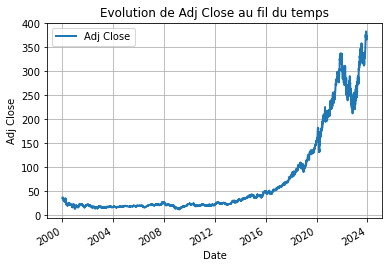

In [39]:
# Tracer le graphique
plt.figure(figsize=(10, 6))
MSFT_df.plot(x='Date', y='Adj Close', label='Adj Close', linewidth=2)
plt.title('Evolution de Adj Close au fil du temps')
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.grid(True)
plt.show()

Text(0.5, 1.0, 'Stock Price of Microsoft over the Years')

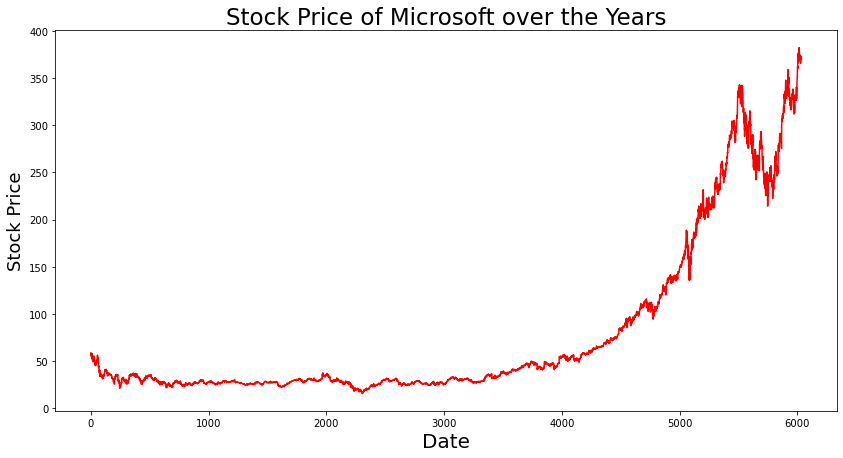

In [41]:
# nalyzing Stock Prices of Microsft over the Years
MSFT_df['Date'] = pd.to_datetime(MSFT_df.Date,format='%m/%d/%Y %H:%M:%S')
df.index = MSFT_df['Date']
plt.figure(figsize=(14,7))
plt.plot(MSFT_df['Close'], label='Close Price history',color='r')
plt.xlabel('Date',size=20)
plt.ylabel('Stock Price',size=18)
plt.title('Stock Price of Microsoft over the Years',size=23)

## 2. Setting the Target Variable and Selecting the Features

Méthode 01: Définir adjst clode comme target

In [8]:
#Set Target Variable
output_var = pd.DataFrame(MSFT_df['Adj Close'])
#Selecting the Features
features = ['Open', 'High', 'Low', 'Volume']

In [9]:
#Scaling
scaler = MinMaxScaler()
feature_transform = scaler.fit_transform(MSFT_df[features])
feature_transform= pd.DataFrame(columns=features, data=feature_transform, index=df.index)
feature_transform.head()

,Open,High,Low,Volume
0,0.117993,0.118511,0.113215,0.078480
1,0.112821,0.116476,0.113559,0.080006
2,0.109514,0.115459,0.109603,0.097038
3,0.110955,0.112069,0.108226,0.081475
4,0.106122,0.109865,0.106764,0.093532


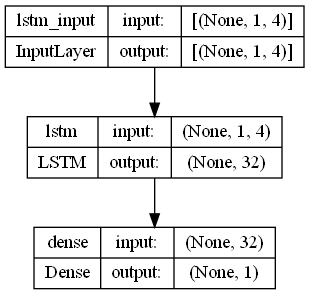

In [10]:
#Creating a Training Set and a Test Set for Stock Market Prediction
#Splitting to Training set and Test set
timesplit= TimeSeriesSplit(n_splits=10)
for train_index, test_index in timesplit.split(feature_transform):
        X_train, X_test = feature_transform[:len(train_index)], feature_transform[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = output_var[:len(train_index)].values.ravel(), output_var[len(train_index): (len(train_index)+len(test_index))].values.ravel()
        
        
# Data Processing For LSTM
#Process the data for LSTM
trainX =np.array(X_train)
testX =np.array(X_test)
X_train = trainX.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = testX.reshape(X_test.shape[0], 1, X_test.shape[1])

#Building the LSTM Model
lstm = Sequential()
lstm.add(LSTM(32, input_shape=(1, trainX.shape[1]), activation='relu', return_sequences=False))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error', optimizer='adam')
plot_model(lstm, show_shapes=True, show_layer_names=True)




In [11]:
history=lstm.fit(X_train, y_train, epochs=100, batch_size=8, verbose=1, shuffle=False)

Epoch 1/100
686/686 [==============================] - 4s 3ms/step - loss: 2474.8218
Epoch 2/100
686/686 [==============================] - 3s 4ms/step - loss: 1160.8405
Epoch 3/100
686/686 [==============================] - 2s 3ms/step - loss: 791.6982
Epoch 4/100
686/686 [==============================] - 2s 3ms/step - loss: 504.9101
Epoch 5/100
686/686 [==============================] - 2s 3ms/step - loss: 256.0602
Epoch 6/100
686/686 [==============================] - 2s 3ms/step - loss: 105.6355
Epoch 7/100
686/686 [==============================] - 2s 3ms/step - loss: 39.4208
Epoch 8/100
686/686 [==============================] - 2s 3ms/step - loss: 16.7148
Epoch 9/100
686/686 [==============================] - 2s 3ms/step - loss: 9.2798
Epoch 10/100
686/686 [==============================] - 2s 3ms/step - loss: 6.4095
Epoch 11/100
686/686 [==============================] - 2s 3ms/step - loss: 4.8949
Epoch 12/100
686/686 [==============================] - 2s 3ms/step - loss: 4.00

686/686 [==============================] - 2s 3ms/step - loss: 6.9943
Epoch 100/100
686/686 [==============================] - 2s 3ms/step - loss: 6.9893


In [12]:
#LSTM Prediction
y_pred= lstm.predict(X_test)

18/18 [==============================] - 0s 2ms/step


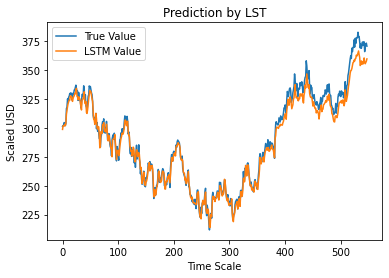

In [13]:
#Predicted vs True Adj Close Value – LSTM
plt.plot(y_test, label='True Value')
plt.plot(y_pred, label='LSTM Value')
plt.title('Prediction by LST')
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.show()

In [26]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Charger vos données
# MSFT_df = pd.read_excel('Chemin/vers/votre/fichier/Excel.xlsx')

# Créer la variable cible (classe)
bins = [-float('inf'), -0.02, 0.02, float('inf')]
labels = ['Baisse', 'Stabilité', 'Hausse']
MSFT_df['Target_Class'] = pd.cut(MSFT_df['Adj Close'].pct_change(), bins=bins, labels=labels)

# Sélectionner les caractéristiques
features = ['Open', 'High', 'Low', 'Volume', 'MACD_Line', 'MACD_Signal', 'MACD_Histogram', 'RSI', 'ATR', 'CMF']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(MSFT_df[features], MSFT_df['Target_Class'], test_size=0.2, random_state=42)

# Normaliser les caractéristiques
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Créer et entraîner le modèle SVM
svm_model = SVC(kernel='linear', C=1)  # Vous pouvez ajuster les hyperparamètres
svm_model.fit(X_train_scaled, y_train)

# Prédictions sur l'ensemble de test
y_pred = svm_model.predict(X_test_scaled)

# Évaluer les performances
accuracy = accuracy_score(y_test, y_pred)
classification_report_result = classification_report(y_test, y_pred)

# Afficher les résultats
print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:')
print(classification_report_result)


ValueError: Input contains NaN

In [42]:
MSFT_df['Target'] = MSFT_df['Close'].pct_change() > 0  # Par exemple, variation positive comme target

# Variables explicatives basées sur les indicateurs MACD
MSFT_df['MACD_Line'] = MSFT_df['Close'].ewm(span=12).mean() - MSFT_df['Close'].ewm(span=26).mean()
MSFT_df['MACD_Signal'] = MSFT_df['MACD_Line'].ewm(span=9).mean()
MSFT_df['MACD_Histogram'] = MSFT_df['MACD_Line'] - MSFT_df['MACD_Signal']

# Variables explicatives basées sur l'indicateur RSI
N = 14  # Vous pouvez ajuster N selon vos besoins
delta = MSFT_df['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=N).mean()
avg_loss = loss.rolling(window=N).mean()
rs = avg_gain / avg_loss
MSFT_df['RSI'] = 100 - (100 / (1 + rs))

# Variables explicatives basées sur l'indicateur ATR
N_ATR = 14  # Vous pouvez ajuster N_ATR selon vos besoins
tr = pd.DataFrame(index=MSFT_df.index)
tr['HL'] = MSFT_df['High'] - MSFT_df['Low']
tr['HC'] = abs(MSFT_df['High'] - MSFT_df['Close'].shift())
tr['LC'] = abs(MSFT_df['Low'] - MSFT_df['Close'].shift())
tr['TrueRange'] = tr[['HL', 'HC', 'LC']].max(axis=1)
MSFT_df['ATR'] = tr['TrueRange'].rolling(window=N_ATR).mean()

# Variables explicatives basées sur l'indicateur de volume (CMF)
N_CMF = 21  # Vous pouvez ajuster N_CMF selon vos besoins
MSFT_df['MF_Multiplier'] = ((MSFT_df['Close'] - MSFT_df['Low']) - (MSFT_df['High'] - MSFT_df['Close'])) / (MSFT_df['High'] - MSFT_df['Low'])
MSFT_df['MF_Volume'] = MSFT_df['MF_Multiplier'] * MSFT_df['Volume']
MSFT_df['CMF'] = MSFT_df['MF_Volume'].rolling(window=N_CMF).sum() / MSFT_df['Volume'].rolling(window=N_CMF).sum()

# Autres variables explicatives
# Ajoutez d'autres variables explicatives selon vos besoins...

# Afficher le DataFrame avec les nouvelles features
print(MSFT_df.head())


        Date      Open     High       Low     Close  Adj Close    Volume  \
0 2000-01-03  58.68750  59.3125  56.00000  58.28125  36.132240  53228400   
1 2000-01-04  56.78125  58.5625  56.12500  56.31250  34.911697  54119000   
2 2000-01-05  55.56250  58.1875  54.68750  56.90625  35.279823  64059600   
3 2000-01-06  56.09375  56.9375  54.18750  55.00000  34.098007  54976600   
4 2000-01-07  54.31250  56.1250  53.65625  55.71875  34.543606  62013600   

   Target  MACD_Line  MACD_Signal  MACD_Histogram  RSI  ATR  MF_Multiplier  \
0   False   0.000000     0.000000        0.000000  NaN  NaN       0.377358   
1   False  -0.044171    -0.024539       -0.019631  NaN  NaN      -0.846154   
2    True  -0.037870    -0.030003       -0.007867  NaN  NaN       0.267857   
3   False  -0.102901    -0.054697       -0.048204  NaN  NaN      -0.409091   
4    True  -0.107470    -0.070396       -0.037074  NaN  NaN       0.670886   

      MF_Volume  CMF  
0  2.008619e+07  NaN  
1 -4.579300e+07  NaN  
2  1.

In [16]:
MSFT_df

,Date,Open,High,Low,Close,Adj Close,Volume,Day,Month,Year,...,RSI,Target_Class,Target,MACD_Line,MACD_Signal,MACD_Histogram,ATR,MF_Multiplier,MF_Volume,CMF
0,2000-01-03,58.687500,59.312500,56.000000,58.281250,36.132240,53228400,3,1,2000,...,NaN,NaN,False,0.000000,0.000000,0.000000,NaN,0.377358,2.008619e+07,NaN
1,2000-01-04,56.781250,58.562500,56.125000,56.312500,34.911697,54119000,4,1,2000,...,NaN,Baisse,False,-0.044171,-0.024539,-0.019631,NaN,-0.846154,-4.579300e+07,NaN
2,2000-01-05,55.562500,58.187500,54.687500,56.906250,35.279823,64059600,5,1,2000,...,NaN,Stabilité,True,-0.037870,-0.030003,-0.007867,NaN,0.267857,1.715882e+07,NaN
3,2000-01-06,56.093750,56.937500,54.187500,55.000000,34.098007,54976600,6,1,2000,...,NaN,Baisse,False,-0.102901,-0.054697,-0.048204,NaN,-0.409091,-2.249043e+07,NaN
4,2000-01-07,54.312500,56.125000,53.656250,55.718750,34.543606,62013600,7,1,2000,...,NaN,Stabilité,True,-0.107470,-0.070396,-0.037074,NaN,0.670886,4.160406e+07,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6026,2023-12-14,373.309998,373.760010,364.130005,365.929993,365.929993,43277500,14,12,2023,...,37.483691,Baisse,False,3.931188,6.062915,-2.131727,6.724287,-0.626171,-2.709911e+07,0.268348
6027,2023-12-15,366.850006,372.399994,366.279999,370.730011,370.730011,78478200,15,12,2023,...,42.050081,Stabilité,True,3.541488,5.558630,-2.017142,6.869287,0.454253,3.564900e+07,0.308570
6028,2023-12-18,369.450012,373.000000,368.679993,372.649994,372.649994,21802900,18,12,2023,...,39.396488,Stabilité,True,3.348970,5.116698,-1.767728,6.832145,0.837960,1.826997e+07,0.299666
6029,2023-12-19,371.489990,373.260010,369.839996,373.260010,373.260010,20603700,19,12,2023,...,43.669321,Stabilité,True,3.208634,4.735085,-1.526451,6.586432,1.000000,2.060370e+07,0.357320


In [ ]:
def calculate_trend(close_prices):
    # Initialize the target column with neutral values
    target = pd.Series(index=close_prices.index, dtype=int).fillna(0)

Calculate the percentage change between the current closing price and the closing price five days later
    pct_change = 100 * (close_prices.shift(-5) - close_prices) / close_prices

Determine the trend
    target[pct_change > 2] = 1  # Bullish trend
    target[pct_change < -2] = -1  # Bearish trend

Return the target series
    return target.astype(int)

### var à expliquer 

In [46]:

# Calculer la variation en pourcentage sur 5 jours
MSFT_df['Variation_5days'] = MSFT_df['Adj Close'].pct_change(5) * 100

# Définir la variable à expliquer (Tendance) en fonction des conditions
MSFT_df['Tendance'] = ''  # Initialisation avec 'Stable' par défaut
MSFT_df.loc[MSFT_df['Variation_5days'] / MSFT_df['Variation_5days'].shift(-5) > 0.02, 'Tendance'] = 'Hausse'
MSFT_df.loc[MSFT_df['Variation_5days'] / MSFT_df['Variation_5days'].shift(-5) < -0.02, 'Tendance'] = 'Baisse'
MSFT_df.loc[((MSFT_df['Variation_5days'] / MSFT_df['Variation_5days'].shift(-5)) > -0.02) & ((MSFT_df['Variation_5days'] / MSFT_df['Variation_5days'].shift(5)) < 0.02), 'Tendance'] = 'Stable'

# Afficher le DataFrame avec la nouvelle variable à expliquer
print(MSFT_df[['Adj Close', 'Variation_5days', 'Tendance']])


       Adj Close  Variation_5days Tendance
0      36.132240              NaN         
1      34.911697              NaN         
2      35.279823              NaN         
3      34.098007              NaN         
4      34.543606              NaN         
...          ...              ...      ...
6026  365.929993        -1.353287         
6027  370.730011        -0.935254         
6028  372.649994         0.363589         
6029  373.260010        -0.299160         
6030  370.619995        -1.001683         

[6031 rows x 3 columns]


In [47]:
MSFT_df[MSFT_df['Tendance']=='Stable']

,Date,Open,High,Low,Close,Adj Close,Volume,Target,MACD_Line,MACD_Signal,...,RSI,ATR,MF_Multiplier,MF_Volume,CMF,Variation_5days,Tendance,EMA_12,EMA_26,Signal_MACD
14,2000-01-24,51.898438,52.843750,50.406250,50.625000,31.385658,63597600,False,-1.460546,-0.294093,...,31.411229,2.756696,-0.820513,-5.218265e+07,-0.134991,-9.799578,Stable,54.108420,55.568965,-0.991045
20,2000-02-01,49.250000,51.625000,48.843750,51.468750,31.908762,70196600,True,-1.996771,-0.813142,...,41.680129,2.555804,0.887640,6.230934e+07,-0.042580,0.121603,Stable,51.510104,53.506875,-1.713465
21,2000-02-02,51.218750,51.968750,50.250000,50.406250,31.250034,49915600,False,-1.936919,-0.848674,...,43.288591,2.502232,-0.818182,-4.084004e+07,-0.088093,1.446515,Stable,51.340281,53.277199,-1.758155
22,2000-02-03,51.031250,52.093750,50.062500,51.812500,32.121883,49186000,True,-1.755773,-0.850310,...,44.499179,2.392857,0.723077,3.556526e+07,-0.027558,4.936760,Stable,51.412930,53.168703,-1.757679
28,2000-02-11,52.437500,52.437500,49.562500,49.968750,30.978819,115559000,False,-0.897311,-0.435803,...,48.217317,2.129464,-0.717391,-8.290102e+07,0.002176,-6.216982,Stable,52.067918,52.965228,-1.163702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,2023-10-31,338.850006,339.000000,334.690002,338.109985,337.425140,20265300,True,2.668738,1.889152,...,55.173641,8.077859,0.587000,1.189573e+07,-0.068369,2.293283,Stable,332.260335,329.591596,1.889152
5997,2023-11-02,347.239990,348.829987,344.769989,348.320007,347.614471,24348100,True,4.419670,2.664620,...,67.013702,8.148575,0.748778,1.823133e+07,-0.000480,6.230745,Stable,336.528762,332.109092,2.664620
6017,2023-12-01,376.760010,378.160004,371.309998,374.510010,374.510010,33020400,False,9.742684,10.579869,...,54.769408,6.011431,-0.065691,-2.169135e+06,0.235812,-0.773649,Stable,374.513419,364.770735,10.579869
6021,2023-12-07,368.230011,371.450012,366.320007,370.950012,370.950012,23118900,True,6.247176,8.574026,...,44.949691,6.626428,0.805068,1.861230e+07,0.238533,-2.100761,Stable,372.501043,366.253867,8.574026


### var explicative

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# 1. Indicateurs MACD
MSFT_df['EMA_12'] = MSFT_df['Close'].ewm(span=12, adjust=False).mean()
MSFT_df['EMA_26'] = MSFT_df['Close'].ewm(span=26, adjust=False).mean()
MSFT_df['MACD_Line'] = MSFT_df['EMA_12'] - MSFT_df['EMA_26']
MSFT_df['Signal_MACD'] = MSFT_df['MACD_Line'].ewm(span=9, adjust=False).mean()
MSFT_df['MACD_Histogram'] = MSFT_df['MACD_Line'] - MSFT_df['Signal_MACD']

# 2. Indicateurs RSI
N_RSI = 14
delta = MSFT_df['Close'].diff(1)
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=N_RSI, min_periods=1).mean()
avg_loss = loss.rolling(window=N_RSI, min_periods=1).mean()
rs = avg_gain / avg_loss
MSFT_df['RSI'] = 100 - (100 / (1 + rs))

# 3. Indicateurs ATR
N_ATR = 14
tr = pd.DataFrame(index=MSFT_df.index)
tr['HL'] = MSFT_df['High'] - MSFT_df['Low']
tr['HC'] = abs(MSFT_df['High'] - MSFT_df['Close'].shift())
tr['LC'] = abs(MSFT_df['Low'] - MSFT_df['Close'].shift())
tr['TrueRange'] = tr[['HL', 'HC', 'LC']].max(axis=1)
MSFT_df['ATR'] = tr['TrueRange'].rolling(window=N_ATR, min_periods=1).mean()

# 4. Indicateurs Volume de transactions (CMF)
N_CMF = 21
MF_Multiplier = ((MSFT_df['Close'] - MSFT_df['Low']) - (MSFT_df['High'] - MSFT_df['Close'])) / (MSFT_df['High'] - MSFT_df['Low'])
MSFT_df['MF_Volume'] = MF_Multiplier * MSFT_df['Volume']
MSFT_df['CMF'] = MSFT_df['MF_Volume'].rolling(window=N_CMF, min_periods=1).sum() / MSFT_df['Volume'].rolling(window=N_CMF, min_periods=1).sum()


#autres indicateurs 

# # Indicateurs basés sur les prix
# MSFT_df['Price_Range'] = MSFT_df['High'] - MSFT_df['Low']
# MSFT_df['Open_Close_Diff'] = MSFT_df['Open'] - MSFT_df['Close']

# # Indicateurs basés sur le volume
# MSFT_df['Buy_Sell_Ratio'] = MSFT_df['Volume'].diff()
# MSFT_df['Accumulated_Volume'] = MSFT_df['Volume'].cumsum()

# # Mesures de performance
# MSFT_df['Daily_Return'] = MSFT_df['Close'].pct_change()
# MSFT_df['Cumulative_Return'] = (1 + MSFT_df['Daily_Return']).cumprod()

# # Indicateurs de risque
# MSFT_df['Risk_Reward_Ratio'] = MSFT_df['Daily_Return'] / MSFT_df['Daily_Return'].shift(1)
# MSFT_df['Volatility'] = MSFT_df['Daily_Return'].rolling(window=20).std()

# # Afficher le DataFrame avec les nouvelles features
# print(MSFT_df[['Close', 'Price_Range', 'Open_Close_Diff', 'Buy_Sell_Ratio', 'Accumulated_Volume', 'Daily_Return', 'Cumulative_Return', 'Risk_Reward_Ratio', 'Volatility']])

# # Afficher le DataFrame avec les nouvelles features
# print(MSFT_df[['Close', 'EMA_12', 'EMA_26', 'MACD_Line', 'Signal_MACD', 'MACD_Histogram', 'RSI', 'ATR', 'CMF']])



In [45]:
MSFT_df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Target',
       'MACD_Line', 'MACD_Signal', 'MACD_Histogram', 'RSI', 'ATR',
       'MF_Multiplier', 'MF_Volume', 'CMF', 'Variation_5days', 'Tendance',
       'EMA_12', 'EMA_26', 'Signal_MACD'],
      dtype='object')

## 8 Différentes modélisations de la variable à expliquer (target)

### 1.  Régression logistique :

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Supprimer les lignes avec des valeurs manquantes
MSFT_df.dropna(inplace=True)

# Sélection des variables explicatives
# features = ['EMA_12', 'EMA_26', 'MACD_Line', 'Signal_MACD', 'MACD_Histogram', 'RSI', 'ATR', 'CMF']
features = ['EMA_12', 'EMA_26', 'MACD_Line', 'Signal_MACD', 'MACD_Histogram', 'RSI', 'ATR', 'CMF',
            'Price_Range', 'Open_Close_Diff', 'Buy_Sell_Ratio', 'Accumulated_Volume', 
            'Daily_Return', 'Cumulative_Return', 'Volatility']

# Sélection de la variable à expliquer
target = 'Tendance'

# Création d'un DataFrame avec les features sélectionnées
X = MSFT_df[features]

# Encodage de la variable à expliquer (Tendance)
y = MSFT_df[target].astype('category').cat.codes

# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardisation des features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Entraînement du modèle de régression logistique
model = LogisticRegression(max_iter=1000, multi_class='multinomial')
model.fit(X_train_scaled, y_train)

# Prédictions sur l'ensemble de test
y_pred = model.predict(X_test_scaled)

# Évaluation du modèle
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy Score: 0.5378850957535387

Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.57      0.56       611
           1       0.52      0.52      0.52       577
           2       0.00      0.00      0.00        13

    accuracy                           0.54      1201
   macro avg       0.36      0.36      0.36      1201
weighted avg       0.53      0.54      0.53      1201



C:\Users\bouch\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\bouch\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\bouch\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


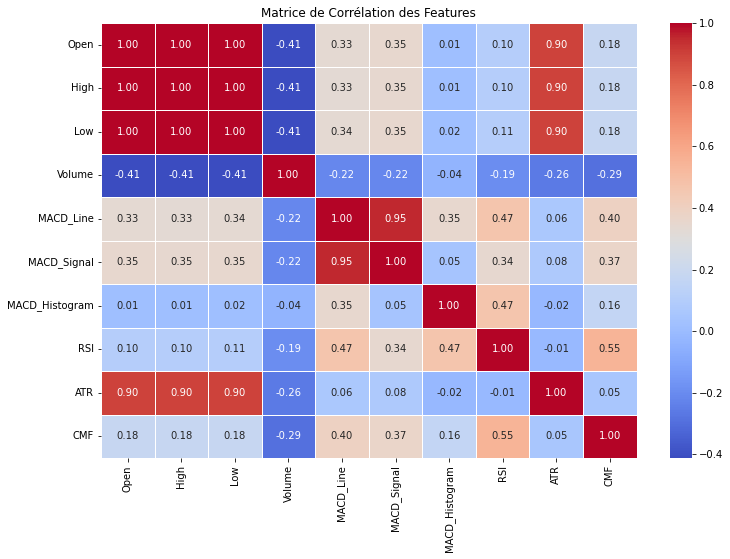

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Création d'un DataFrame avec les features sélectionnées
X = MSFT_df[features]

# Calcul de la matrice de corrélation
correlation_matrix = X.corr()

# Affichage de la matrice de corrélation
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matrice de Corrélation des Features')
plt.show()


In [32]:
non_numeric_columns = MSFT_df.select_dtypes(include=['object']).columns
print(non_numeric_columns)



Index(['Tendance'], dtype='object')


In [33]:
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder

# Créez une instance de LabelEncoder
label_encoder = LabelEncoder()

# Appliquez l'encodage de label à la colonne 'Tendance'
MSFT_df['Tendance'] = label_encoder.fit_transform(MSFT_df['Tendance'])

# Ajoutez une colonne de constante pour représenter l'intercept
X_train_scaled_with_intercept = sm.add_constant(X_train_scaled)

# Créez un modèle de régression logistique avec statsmodels
model = sm.OLS(y_train, X_train_scaled_with_intercept)

# Ajustez le modèle
results = model.fit()

# Affichez les résultats (p-values)
print(results.summary())

# Supprimez les caractéristiques avec les p-values les plus élevées
while results.pvalues.max() > 0.05:
    max_pvalue_index = results.pvalues.idxmax()
    X_train_scaled_with_intercept = X_train_scaled_with_intercept.drop(max_pvalue_index, axis=1)
    
    # Réajustez le modèle après avoir retiré une caractéristique
    model = sm.OLS(y_train, X_train_scaled_with_intercept)
    results = model.fit()

# Affichez les résultats finaux
print(results.summary())


ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [25]:
from sklearn.feature_selection import RFE

# Création du modèle de régression logistique
model = LogisticRegression(max_iter=1000, multi_class='multinomial')

# Utilisation de RFE pour la sélection de caractéristiques
rfe = RFE(model, n_features_to_select=1)  # Choisissez le nombre de caractéristiques à conserver
X_train_rfe = rfe.fit_transform(X_train_scaled, y_train)
X_test_rfe = rfe.transform(X_test_scaled)

# Entraînement du modèle sur les données réduites
model.fit(X_train_rfe, y_train)

# Prédictions sur l'ensemble de test
y_pred_rfe = model.predict(X_test_rfe)

# Évaluation du modèle avec la sélection de caractéristiques
print("Accuracy Score (avec sélection de caractéristiques):", accuracy_score(y_test, y_pred_rfe))
print("\nClassification Report (avec sélection de caractéristiques):\n", classification_report(y_test, y_pred_rfe))


Accuracy Score (avec sélection de caractéristiques): 0.5187343880099917

Classification Report (avec sélection de caractéristiques):
               precision    recall  f1-score   support

           0       0.52      0.81      0.63       611
           1       0.52      0.22      0.31       577
           2       0.00      0.00      0.00        13

    accuracy                           0.52      1201
   macro avg       0.35      0.34      0.31      1201
weighted avg       0.51      0.52      0.47      1201



C:\Users\bouch\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\bouch\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\bouch\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import plot_confusion_matrix

# Plot Confusion Matrix
disp = plot_confusion_matrix(model, X_test_scaled, y_test, cmap=plt.cm.Blues, normalize='true')
disp.figure_.suptitle("Normalized Confusion Matrix")
plt.show()


### 2.  Régression linéaire 

### 3.  Arbre de décision : 

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Sélection de la variable à expliquer (Tendance)
target = 'Tendance'

# Encodage de la variable à expliquer (Tendance)
y = MSFT_df[target].astype('category').cat.codes

# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Création d'un arbre de décision
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, y_train)

# Prédictions sur l'ensemble de test
y_pred_tree = tree_model.predict(X_test)

# Évaluation du modèle
print("Accuracy Score:", accuracy_score(y_test, y_pred_tree))
print("\nClassification Report:\n", classification_report(y_test, y_pred_tree))


In [ ]:
MSFT_df[MSFT_df['Tendance']=='Hausse']

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Visualisation de l'arbre de décision
plt.figure(figsize=(12, 8))
plot_tree(tree_model, filled=True, feature_names=features, class_names=target, rounded=True)
plt.show()


### 4.  Random forest 

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Supprimer les lignes avec des valeurs manquantes
MSFT_df.dropna(inplace=True)

# Sélection des variables explicatives
features = ['EMA_12', 'EMA_26', 'MACD_Line', 'Signal_MACD', 'MACD_Histogram', 'RSI', 'ATR', 'CMF',
            'Price_Range', 'Open_Close_Diff', 'Buy_Sell_Ratio', 'Accumulated_Volume', 
            'Daily_Return', 'Cumulative_Return', 'Volatility']

# Sélection de la variable à expliquer
target = 'Tendance'

# Création d'un DataFrame avec les features sélectionnées
X = MSFT_df[features]

# Encodage de la variable à expliquer (Tendance)
y = MSFT_df[target].astype('category').cat.codes

# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardisation des features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Entraînement du modèle Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Prédictions sur l'ensemble de test
y_pred_rf = rf_model.predict(X_test_scaled)

# Évaluation du modèle Random Forest
print("Accuracy Score (Random Forest):", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report (Random Forest):\n", classification_report(y_test, y_pred_rf))


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

# Définir les hyperparamètres à rechercher
param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Créer un classificateur RandomForest
rf_classifier = RandomForestClassifier(random_state=42)

# Utiliser RandomizedSearchCV pour la recherche aléatoire des hyperparamètres
random_search = RandomizedSearchCV(
    rf_classifier, param_distributions=param_dist, n_iter=10, cv=5, scoring='accuracy', random_state=42, n_jobs=-1
)

# Ajuster le modèle aux données d'entraînement
random_search.fit(X_train_scaled, y_train)

# Afficher les meilleurs hyperparamètres trouvés
print("Meilleurs hyperparamètres:", random_search.best_params_)

# Prédictions sur l'ensemble de test avec les meilleurs hyperparamètres
y_pred_random_search = random_search.predict(X_test_scaled)

# Évaluation du modèle après la recherche aléatoire
print("Accuracy Score (Random Forest - RandomizedSearchCV):", accuracy_score(y_test, y_pred_random_search))
print("\nClassification Report (Random Forest - RandomizedSearchCV):\n", classification_report(y_test, y_pred_random_search))


### 5. SVM 

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {'C': [0.1, 1, 10, 100], 'gamma': [0.01, 0.1, 1, 10]}

random_search = RandomizedSearchCV(SVC(kernel='rbf'), param_dist, n_iter=10, cv=5)
random_search.fit(X_train_scaled, y_train)

print("Meilleurs hyperparamètres après recherche aléatoire :", random_search.best_params_)
print("Meilleur score après recherche aléatoire :", random_search.best_score_)


In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV

# Supprimer les lignes avec des valeurs manquantes
MSFT_df.dropna(inplace=True)

# Sélection des variables explicatives
features = ['EMA_12', 'EMA_26', 'MACD_Line', 'Signal_MACD', 'MACD_Histogram', 'RSI', 'ATR', 'CMF',
            'Price_Range', 'Open_Close_Diff', 'Buy_Sell_Ratio', 'Accumulated_Volume', 
            'Daily_Return', 'Cumulative_Return', 'Volatility']

# Sélection de la variable à expliquer
target = 'Tendance'

# Création d'un DataFrame avec les features sélectionnées
X = MSFT_df[features]

# Encodage de la variable à expliquer (Tendance)
y = MSFT_df[target].astype('category').cat.codes

# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardisation des features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Définir les hyperparamètres à ajuster
param_dist = {'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf']}

# Créer le modèle SVM
svm_model = SVC()

# Recherche aléatoire des meilleurs hyperparamètres
random_search = RandomizedSearchCV(svm_model, param_distributions=param_dist, n_iter=5, scoring='accuracy', n_jobs=-1, cv=5, random_state=42)
random_search.fit(X_train_scaled, y_train)

# Afficher les meilleurs hyperparamètres
print("Meilleurs hyperparamètres:", random_search.best_params_)

# Prédictions sur l'ensemble de test
y_pred_svm = random_search.predict(X_test_scaled)

# Évaluation du modèle SVM
print("Accuracy Score (SVM):", accuracy_score(y_test, y_pred_svm))
print("\nClassification Report (SVM):\n", classification_report(y_test, y_pred_svm))


In [ ]:
from sklearn.svm import SVC

# Meilleurs hyperparamètres obtenus après la recherche aléatoire
best_params = {'gamma': 0.01, 'C': 100}

# Création du modèle SVM avec les meilleurs hyperparamètres
best_svm_model = SVC(kernel='rbf', **best_params)
best_svm_model.fit(X_train_scaled, y_train)

# Prédictions sur l'ensemble de test
y_pred_svm = best_svm_model.predict(X_test_scaled)

# Évaluation du modèle SVM
print("Accuracy Score (SVM avec meilleurs hyperparamètres):", accuracy_score(y_test, y_pred_svm))
print("\nClassification Report (SVM avec meilleurs hyperparamètres):\n", classification_report(y_test, y_pred_svm))


### 6. K plus proches voisins (KNN)

In [ ]:


# Création d'un modèle k-NN
knn_model = KNeighborsClassifier(n_neighbors=5)

# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardisation des features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Entraînement du modèle k-NN
knn_model.fit(X_train_scaled, y_train)

# Prédictions sur l'ensemble de test
y_pred_knn = knn_model.predict(X_test_scaled)

# Évaluation du modèle k-NN
print("Accuracy Score (k-NN):", accuracy_score(y_test, y_pred_knn))
print("\nClassification Report (k-NN):\n", classification_report(y_test, y_pred_knn))


### 7. Gradient Boosting:

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Création d'un modèle Gradient Boosting
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardisation des features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Entraînement du modèle Gradient Boosting
gb_model.fit(X_train_scaled, y_train)

# Prédictions sur l'ensemble de test
y_pred_gb = gb_model.predict(X_test_scaled)

# Évaluation du modèle Gradient Boosting
print("Accuracy Score (Gradient Boosting):", accuracy_score(y_test, y_pred_gb))
print("\nClassification Report (Gradient Boosting):\n", classification_report(y_test, y_pred_gb))


### 8. Réseaux de neurones récurrents (RNN)

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# Charger les données et effectuer le prétraitement
# (Assurez-vous que MSFT_df contient toutes les colonnes nécessaires, y compris 'Tendance')
# ...

# Sélection des variables explicatives
features = ['EMA_12', 'EMA_26', 'MACD_Line', 'Signal_MACD', 'MACD_Histogram', 'RSI', 'ATR', 'CMF',
            'Price_Range', 'Open_Close_Diff', 'Buy_Sell_Ratio', 'Accumulated_Volume', 
            'Daily_Return', 'Cumulative_Return', 'Volatility']

# Sélection de la variable à expliquer
target = 'Tendance'

# Création d'un DataFrame avec les features sélectionnées
X = MSFT_df[features]

# Encodage de la variable à expliquer (Tendance)
le = LabelEncoder()
y = le.fit_transform(MSFT_df[target])

# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardisation des features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Réorganiser les données pour un format RNN
X_train_rnn = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_rnn = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

# Création du modèle RNN simple avec une couche LSTM
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Compiler le modèle
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entraîner le modèle
model.fit(X_train_rnn, y_train, epochs=10, batch_size=32, validation_data=(X_test_rnn, y_test))


In [ ]:
# Évaluation du modèle
loss, accuracy = model.evaluate(X_test_rnn, y_test)

# Affichage des résultats
print(f"Loss on test set: {loss}")
print(f"Accuracy on test set: {accuracy}")


In [ ]:
# Prédictions sur le jeu de test
y_pred = model.predict(X_test_rnn)

# Convertir les prédictions en classes (0, 1, 2)
predicted_classes = np.argmax(y_pred, axis=1)

# Affichage du rapport de classification et de la matrice de confusion
from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report:\n", classification_report(y_test, predicted_classes))
print("Confusion Matrix:\n", confusion_matrix(y_test, predicted_classes))


### 9.Réseaux de neurones convolutifs (CNN) 

In [ ]:
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import LabelEncoder
# from sklearn.metrics import classification_report, accuracy_score

# Supposons que vous ayez déjà préparé vos données dans X et y
# X est un tableau 3D contenant vos séquences temporelles (échantillons, temps, caractéristiques)
# y est un tableau 1D contenant les étiquettes de classe

# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardisation des données
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Encodage des étiquettes de classe
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

model = Sequential()
model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))  # 3 classes pour les tendances possibles

# Compilation du modèle
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Entraînement du modèle
model.fit(X_train, y_train_encoded, epochs=10, batch_size=64, validation_split=0.1)

# Évaluation du modèle
# Prédictions sur l'ensemble de test
y_pred_probabilities = model.predict(X_test)
y_pred = np.argmax(y_pred_probabilities, axis=1)

# Évaluation du modèle
accuracy = accuracy_score(y_test_encoded, y_pred)
print("Accuracy Score:", accuracy)


In [ ]:
from sklearn.metrics import classification_report

# Évaluation du modèle
classification_rep = classification_report(y_test_encoded, y_pred)
print("Classification Report:\n", classification_rep)


### 10. Modèles de séquence temporelle (comme ARIMA)

In [ ]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error


In [ ]:

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [ ]:



# Tracez l'autocorrélation et l'autocorrélation partielle
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# ACF (Autocorrelation Function)
plot_acf(MSFT_df['Close'], lags=40, ax=ax1)  # Assurez-vous de remplacer 'Close' par le nom correct de votre colonne

# PACF (Partial Autocorrelation Function)
plot_pacf(MSFT_df['Close'], lags=40, ax=ax2)  # Assurez-vous de remplacer 'Close' par le nom correct de votre colonne

plt.show()


In [ ]:
Variables explicatives

1. Indicateurs MACD
Indicateur MACD Formulation Valeurs des variables

Dans la pratique, les praticiens utilisent l’une des deux règles suivantes pour anticiper les hausses ou
les baisses de tendance à partir du MACD :
- Variation haussière si la ligne MACD est positive MACDt > 0 ou si l’histogramme est positif Ht
> 0 ;
- Variation à la baisse si la ligne MACD est négative MACDt < 0 ou si l’histogramme est négatif
Ht < 0.
2. Indicateurs RSI

- si N = 21, les spécialistes considèrent que la tendance du marché est à la hausse si RSI > 50 et
à la baisse si RSI < 50 ;
- si N = 14, le marché est jugé haussier si RSI > 70 et baissier si RSI < 30.
Les deux règles sont à évaluer en pratique.


3. Indicateurs ATR

Une forte valeur de l’ATR indique une volatilité accrue sur le marché. Un renversement de prix avec
une augmentation de l’ATR peut indiquer un renversement de cours.
Une faible valeur de l’ATR est signe d’une volatilité faible. Une période prolongée de faibles valeurs
d’ATR peut indiquer une zone de consolidation et la possibilité d’un mouvement de continuation.



4. Indicateurs Volume de transactions

L’interprétation est la suivante :
- Lorsque le CMF est supérieur à 0.25 (resp. inférieur à −0.25), le marché est à la hausse : le
prix de clôture et le volume de transactions augmentent ;
- lorsque le CMF est inférieur à −0, 25, il s’agit d’un signal baissier du marché ;
- Si le CMF est reste en dessous de zéro et que le prix de clôture monte, alors il y a un risque
de retournement de marché. 